I'm reading the 2nd edition of the very nice [book](https://webdocs.cs.ualberta.ca/~sutton/book/the-book.html) by Richard S. Sutton and Andrew G. Barto. Here I describe my exploration for the exercises at the end of chapter 1.

Chapter 1 describes value functions and how one may approach the problem of creating a self learning program that plays tic tac toe. Full source code [here](https://github.com/cancandan/reinforcement_learning_book)

`Board`,`Game`,`Player` are the main classes. 

The Board object
====
`Board` holds a list of length 9 named `state` made up of numbers from the set {0,1,2} where 0 means the cell is empty, 1 means the sign of the player who plays first and 2 the sign of second. 9 values correspond to cells from top left to bottom right increasing from left to right and top to bottom.
Here is the `Board` class


In [99]:
class Board:     
    def display(self):
        form = '''
            \t| %s | %s | %s |
            \t-------------
            \t| %s | %s | %s |
            \t-------------
            \t| %s | %s | %s |
            '''
        disp=[]
        for i in self.state:
            if i==0:
                disp.append('-')
            elif i==1:
                disp.append('X')    
            elif i==2:
                disp.append('O')
        return (form % tuple(disp))
            
    def __init__(self,state=None):
        if (state is None):        
            self.state=[0]*9
        else:
            self.state=state
    def __repr__(self):
        return self.display()
    def emptyCells(self):
        return [idx for idx,val in enumerate(self.state) if val==0]
    def newBoard(self,location,sign):
        mycopy=copy.deepcopy(self)
        mycopy.state[location]=sign
        return mycopy
    def __hash__(self):
        return hash(tuple(self.state))
    def __eq__(self,other):
        return tuple(self.state)==tuple(other.state)
    def rotate(self):
        mycopy=copy.deepcopy(self)
        #0>6,1>3,2>0
        #3>7,4>4,5>1
        #6>8,7>5,8>2
        mycopy.state[6]=self.state[0]
        mycopy.state[8]=self.state[6]
        mycopy.state[2]=self.state[8]
        mycopy.state[0]=self.state[2]
        
        mycopy.state[3]=self.state[1]
        mycopy.state[7]=self.state[3]
        mycopy.state[5]=self.state[7]
        mycopy.state[1]=self.state[5]
        return mycopy
#         mycopy.state[4]=self.state[4]
    def reflectHorizontal(self):
        mycopy=copy.deepcopy(self)
        mycopy.state[6]=self.state[0]
        mycopy.state[7]=self.state[1]
        mycopy.state[8]=self.state[2]
        
        mycopy.state[0]=self.state[6]
        mycopy.state[1]=self.state[7]
        mycopy.state[2]=self.state[8]
        return mycopy

The method `newBoard` returns a copy of the current board with the given sign of the player making a move to the specified location. The methods `rotate` and `reflectHorizontal` are necessary in a later in chapter 1.
Here is an empty board

In [101]:
Board()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            

A board with some state

In [102]:
Board([0,1,2,1,0,2,0,0,0])


            	| - | X | O |
            	-------------
            	| X | - | O |
            	-------------
            	| - | - | - |
            

The Game object
====
This object refers to both players and the board, it keeps a history of moves, has a method for sequentially making the players move and a method that checks if the game is finished with a win,loose or a tie.

In [ ]:
class Game:
    def __init__(self,playerOne,playerTwo):
        self.playerOneWin=False
        self.playerOneLoose=False
        self.tie=False
        self.playerOne=playerOne
        self.playerTwo=playerTwo
        self.board=Board()
        self.history=[]                               
        self.addBoardToHistory()
        
    def addBoardToHistory(self):        
        self.history.append(copy.deepcopy(self.board))
    def play(self):        
        if isinstance(self.playerOne,HumanPlayer):
            print self.board
        while(True):
            self.playerOne.makeMove(self)            
            if isinstance(self.playerOne,HumanPlayer) or isinstance(self.playerTwo,HumanPlayer):
                print self.board
            self.addBoardToHistory()
            if self.finished(): break
            
            self.playerTwo.makeMove(self)
            if isinstance(self.playerOne,HumanPlayer) or isinstance(self.playerTwo,HumanPlayer):
                print self.board
            self.addBoardToHistory()
            if self.finished(): break
                    
    def finished(self):
        win,loose=self.playerOne.winLoose(self.board)
        self.win=win
        self.loose=loose
        if not(win or loose):
            empty=self.board.emptyCells()
            if len(empty)==0:
                self.tie=True
        if (self.win or self.loose or self.tie):
            return True
        return False


The Player object
====
The `Player` plays randomly with the probability specified in the constructor and greedily otherwise, where playing greedily means choosing the move with the highest value given by the value function. The value function is simply a dictionary and is maintained within the `Player` object. It maps board states to a score which is a real number between 0 and 1.
Initially the value dict is empty, but gets filled as the program runs when a query for the value of a state is made. The winning combinations are in `wincombn` and they get the score 1, loosing combinations get score 0 and the rest 0.5 initially. Winning combination for a player corresponds to the board state having the same sign vertically, horizontally or diagonally for a player.

The approach described in the book to reinforcement learning is in the method `greedyMove`. Here after iterating on all empty cells and selecting one from the set of best moves we update the score of the previous board state we were at, according to the formula `V(s)=V(s)+alpha*[V(s')-V(s)]`. Here `V(s)` is the value of the old state `V(s')` value of the best move.


In [98]:
class Player:    
    def __init__(self,sign,randomNess=0.1):
        self.V=dict()
        self.sign=sign
        self.opponentSign=(self.sign==1 and 2 or 1)
        self.randomMoveProbability=randomNess
        self.wincombn=[[6, 7, 8], [3, 4, 5], [0, 1, 2], [0, 3, 6], [1, 4, 7], [2, 5, 8],[0, 4, 8], [2, 4, 6]]
        self.alpha=0.1
    def getValueForState(self,board):
        win,loose=self.winLoose(board)
        if win:
            return 1
        if loose:
            return 0
        score=self.V.get(board)    
        if (score is None):            
            self.V[board]=0.5
            return 0.5
        else:
            return score
        
    def winLoose(self,board):
        checks=[[board.state[i] for i in sqn] for sqn in self.wincombn]
        win=(3 in [check.count(self.sign) for check in checks])        
        loose=(3 in [check.count(self.opponentSign) for check in checks])
        return win,loose
            
            
    def randomMove(self,game,empty):                
        rnd=random.randrange(0,len(empty))        
        newBoard=game.board.newBoard(empty[rnd],self.sign)
        game.board=newBoard
    
    def updateValueForState(self,state,newval):
        self.V[state]=newval
        
    def greedyMove(self,game,empty): 
        # greedy move                
        possibleMovesAndScores=dict()
        for cell in empty:
            candidate=game.board.newBoard(cell,self.sign)
            score=self.getValueForState(candidate)
            possibleMovesAndScores[candidate]=score
        
        vals=possibleMovesAndScores.values()
        maxScore=max(vals)
        bestMoves=[k for k,v in possibleMovesAndScores.items() if v==maxScore]
        chooseOne=random.randrange(0,len(bestMoves))
        oneBestMove=bestMoves[chooseOne]
        
        
        if len(game.history)>2:                    
            oldval=self.getValueForState(game.history[-2])
            newval=oldval+self.alpha*(self.getValueForState(oneBestMove)-oldval)
            self.updateValueForState(game.history[-2],newval)
        game.board=oneBestMove
        
    def makeMove(self,game):
        empty=game.board.emptyCells()
        if (random.random()<self.randomMoveProbability):
            return self.randomMove(game,empty)            
        return self.greedyMove(game,empty)

The GameLoop object:
====
This is for bookkeeping the number of wins, losses and ties. It also keeps all played games.

In [ ]:
class GameLoop:
    def __init__(self,playerOne,playerTwo):
        self.wintimes=0
        self.loosetimes=0
        self.tietimes=0
    
    
        self.playerOne=playerOne
        self.playerTwo=playerTwo
        self.games=[]
        
    def run(self,numrounds=10000):
        for i in range(0,numrounds):
            g=Game(self.playerOne,self.playerTwo)
            g.play()
            if (g.win):
                self.wintimes=self.wintimes+1
            if (g.loose):
                self.loosetimes=self.loosetimes+1
            if (g.tie):
                self.tietimes=self.tietimes+1
            self.games.append(g)  

`plotWins` is a utility function for plotting the ratio of number of wins to total games played

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plotWins(gl):
    wins=[g.win for g in gl.games]
    wins_cs=np.array(wins).cumsum()
    avg=[float(val)/(idx+1) for idx,val in enumerate(wins_cs)]
    print avg[-1]
    plt.plot(range(0,len(gl.games)),avg)

Lets run and see what happens:
====
To try it yourself checkout the `tictactoe.py` from the repository and load as follows:

In [ ]:
%run ~/software-projects/RL/tictactoe.py

>Exercise 1.1: Self-Play Suppose, instead of playing against a random
opponent, the reinforcement learning algorithm described above played against
itself. What do you think would happen in this case? Would it learn a different
way of playing?

First player random, second semi greedy (randomness=0.1)
=====

In [126]:
rand11=Player(1,randomNess=1)
greedy12=Player(2,randomNess=0.1)
gl=GameLoop(rand11,greedy12)
gl.run(numrounds=10000)

0.2323


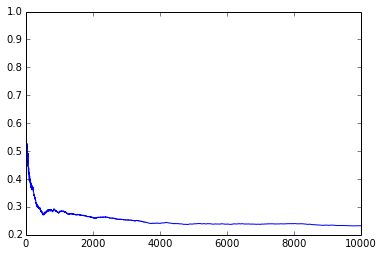

In [128]:
plotWins(gl)

Both players semi greedy (randomness=0.1)
=====

In [129]:
greedy21=Player(1,randomNess=0.1)
greedy22=Player(2,randomNess=0.1)
gl=GameLoop(greedy21,greedy22)
gl.run(numrounds=10000)

0.3121


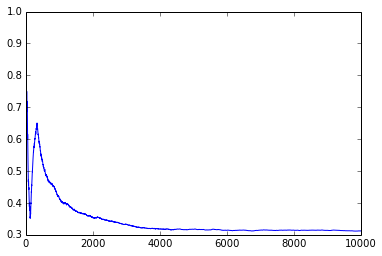

In [130]:
plotWins(gl)

I will play against greedy12

In [133]:
h=HumanPlayer(1)
g=Game(h,greedy12)
g.play()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:0

            	| X | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            

            	| X | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | O |
            
your move:1

            	| X | X | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | O |
            

            	| X | X | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | O | O |
            
your move:2

            	| X | X | X |
            	-------------
            	| - | - | - |
            	-------------
            	| - | O | O |
            


Not very bright, what about greedy22?

In [134]:
h=HumanPlayer(1)
g=Game(h,greedy22)
g.play()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:0

            	| X | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            

            	| X | - | - |
            	-------------
            	| O | - | - |
            	-------------
            	| - | - | - |
            
your move:1

            	| X | X | - |
            	-------------
            	| O | - | - |
            	-------------
            	| - | - | - |
            

            	| X | X | - |
            	-------------
            	| O | - | - |
            	-------------
            	| O | - | - |
            
your move:2

            	| X | X | X |
            	-------------
            	| O | - | - |
            	-------------
            	| O | - | - |
            


Nope, would more iterations help? Running random vs greedy for 100k and trying again

In [135]:
rand11=Player(1,randomNess=1)
greedy12=Player(2,randomNess=0.1)
gl=GameLoop(rand11,greedy12)
gl.run(numrounds=100000)

In [136]:
h=HumanPlayer(1)
g=Game(h,greedy12)
g.play()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:0

            	| X | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            

            	| X | - | O |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:3

            	| X | - | O |
            	-------------
            	| X | - | - |
            	-------------
            	| - | - | - |
            

            	| X | O | O |
            	-------------
            	| X | - | - |
            	-------------
            	| - | - | - |
            
your move:6

            	| X | O | O |
            	-------------
            	| X | - | - |
            	-------------
            	| X | - | - |
            


I win easily, what about greedy vs greedy for 100k?

In [137]:
greedy21=Player(1,randomNess=0.1)
greedy22=Player(2,randomNess=0.1)
gl=GameLoop(greedy21,greedy22)
gl.run(numrounds=100000)

In [140]:
h=HumanPlayer(1)
g=Game(h,greedy22)
g.play()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:0

            	| X | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            

            	| X | - | - |
            	-------------
            	| - | - | O |
            	-------------
            	| - | - | - |
            
your move:1

            	| X | X | - |
            	-------------
            	| - | - | O |
            	-------------
            	| - | - | - |
            

            	| X | X | O |
            	-------------
            	| - | - | O |
            	-------------
            	| - | - | - |
            
your move:8

            	| X | X | O |
            	-------------
            	| - | - | O |
            	-------------
            	| - | - | X |
            

            	| X | X | O |
            	-------------
            	| 

Cool! Another go.

In [141]:
h=HumanPlayer(1)
g=Game(h,greedy22)
g.play()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:1

            	| - | X | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            

            	| - | X | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | O |
            
your move:4

            	| - | X | - |
            	-------------
            	| - | X | - |
            	-------------
            	| - | - | O |
            

            	| - | X | - |
            	-------------
            	| - | X | - |
            	-------------
            	| - | O | O |
            
your move:6

            	| - | X | - |
            	-------------
            	| - | X | - |
            	-------------
            	| X | O | O |
            

            	| - | X | O |
            	-------------
            	| 

Nice! Another go..

In [142]:
h=HumanPlayer(1)
g=Game(h,greedy22)
g.play()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:3

            	| - | - | - |
            	-------------
            	| X | - | - |
            	-------------
            	| - | - | - |
            

            	| - | - | - |
            	-------------
            	| X | O | - |
            	-------------
            	| - | - | - |
            
your move:0

            	| X | - | - |
            	-------------
            	| X | O | - |
            	-------------
            	| - | - | - |
            

            	| X | - | - |
            	-------------
            	| X | O | - |
            	-------------
            	| O | - | - |
            
your move:2

            	| X | - | X |
            	-------------
            	| X | O | - |
            	-------------
            	| O | - | - |
            

            	| X | O | X |
            	-------------
            	| 

Another

In [143]:
h=HumanPlayer(1)
g=Game(h,greedy22)
g.play()


            	| - | - | - |
            	-------------
            	| - | - | - |
            	-------------
            	| - | - | - |
            
your move:4

            	| - | - | - |
            	-------------
            	| - | X | - |
            	-------------
            	| - | - | - |
            

            	| - | - | - |
            	-------------
            	| - | X | - |
            	-------------
            	| - | - | O |
            
your move:2

            	| - | - | X |
            	-------------
            	| - | X | - |
            	-------------
            	| - | - | O |
            

            	| - | - | X |
            	-------------
            	| - | X | - |
            	-------------
            	| O | - | O |
            
your move:7

            	| - | - | X |
            	-------------
            	| - | X | - |
            	-------------
            	| O | X | O |
            

            	| - | - | X |
            	-------------
            	| 

I won!
Seems training more with greedy vs greedy we get a somewhat better player.

>Exercise 1.2: Symmetries Many tic-tac-toe positions appear different but
are really the same because of symmetries. How might we amend the reinforcement
learning algorithm described above to take advantage of this? In what
ways would this improve it? Now think again. Suppose the opponent did not
take advantage of symmetries. In that case, should we? Is it true, then, that
symmetrically equivalent positions should necessarily have the same value?

SymmetryPlayer object
=====
I amend the algorithm by creating a `SymmetryPlayer` object which extends `Player` and overrides the `updateValueForState` where the value function is updated. Instead of updating just the given board state it updates all symmetries, ie. rotation reflection combinations.
I expect there will be faster convergence with `SymmetryPlayer` vs `SymmetryPlayer`. I think although the symmetrically equivalent positions should have the same value ideally, in case the opponent did not take advantage of symmetries we should also not since there might be better ways of exploiting this, ie adapt to play of opponent for more wins. 

In [ ]:
class SymmetryPlayer(Player):
    def __init__(self,sign):
        Player.__init__(self,sign)
    def updateValueForState(self,state,newval):        
        self.V[state]=newval 
        for i in range(0,2):
            state=state.rotate()
            self.V[state]=newval 
            
        reflected=state.reflectHorizontal()
        self.V[reflected]=newval 
        for i in range(0,2):
            reflected=reflected.rotate()
            self.V[reflected]=newval 

SymmetryPlayer vs SymmetryPlayer
====

In [7]:
sym1=SymmetryPlayer(1,randomness=0.1)
sym2=SymmetryPlayer(2,randomness=0.1)
gl=GameLoop(sym1,sym2)
gl.run(numrounds=10000)

0.9073


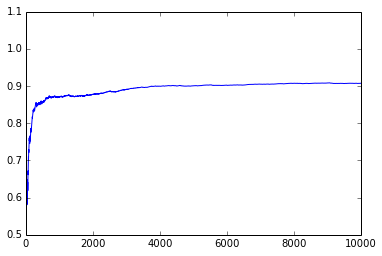

In [12]:
plotWins(gl)

It converges faster compared to greedy vs greedy earliear

Player vs SymmetryPlayer
====

In [14]:
ply1=Player(1,randomness=0.1)
sym2=SymmetryPlayer(2,randomness=0.1)
gl=GameLoop(ply1,sym2)
gl.run(numrounds=10000)

0.8381


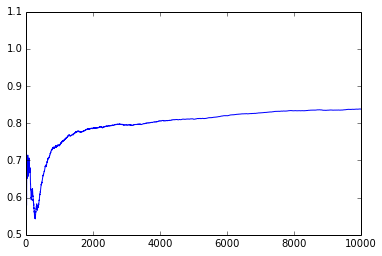

In [15]:
plotWins(gl)

SymmetryPlayer vs Player
====

In [16]:
sym1=SymmetryPlayer(1,randomness=0.1)
ply2=SymmetryPlayer(2,randomness=0.1)
gl=GameLoop(sym1,ply2)
gl.run(numrounds=10000)

0.8555


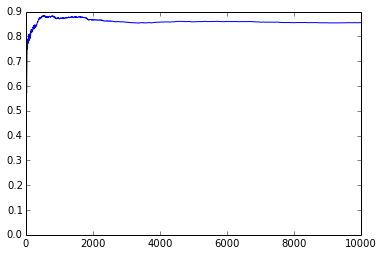

In [17]:
plotWins(gl)

>Exercise 1.3: Greedy Play Suppose the reinforcement learning player was
greedy, that is, it always played the move that brought it to the position that
it rated the best. Would it learn to play better, or worse, than a nongreedy
player? What problems might occur?

In [20]:
pureGreed=Player(1,randomness=0)
semiGreed=Player(2,randomness=0.1)
gl=GameLoop(pureGreed,semiGreed)
gl.run(numrounds=10000)

0.3561


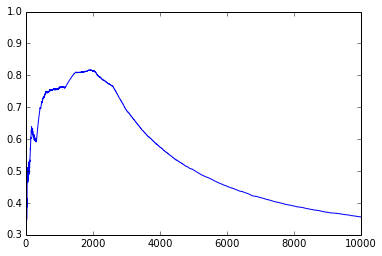

In [21]:
plotWins(gl)

Interesting! The semi greedy player is loosing up around 2000 iterations then steadily improves and eventually plays better than purely greedy player. That should be because purely greedy one memorises bad moves

>Exercise 1.4: Learning from Exploration Suppose learning updates occurred
after all moves, including exploratory moves. If the step-size parameter is
appropriately reduced over time, then the state values would converge to a
set of probabilities. What are the two sets of probabilities computed when we
do, and when we do not, learn from exploratory moves? Assuming that we
do continue to make exploratory moves, which set of probabilities might be
better to learn? Which would result in more wins?

First I need to understand what properly reducing alpha means. I don't know the answer to this question. But here is what we get as unique values of board states after 100k games in a `LearningFromExplorationPlayer` object.

In [3]:
grdy1=Player(1,randomness=0.1)
expl2=LearningFromExplorationPlayer(2,randomness=0.1)
gl=GameLoop(grdy1,expl2)
gl.run(numrounds=100000)

In [9]:
len(set(expl2.V.values()))

249

Lots of values here, meaning no convergence as expected

>Exercise 1.5: Other Improvements Can you think of other ways to improve
the reinforcement learning player? Can you think of any better way to solve
the tic-tac-toe problem as posed?

There is no learning from mistakes in the greedy approach. The player should update the value function for its previous move when it looses.